# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-14 15:46:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [     <=>            ] 201.24M  24.0MB/s    in 9.1s    

2023-10-14 15:46:26 (22.1 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
rmse_for_model = mean_squared_error(y_test, model.predict(X_test), squared=False)
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = mean_squared_error(y_test, [int(y_train.mean())] * X_test.shape[0], squared=False)
best_rmse_metric

10.863228020678134

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя. +
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь +, сделайте шаг градиентного спуска +. Запрещено использовать готовые оптимизаторы + и loss-функции + из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward +. +
3. Запустите обучение на 10 эпохах +, после каждой проверяйте значение целевой метрики на тестовой выборке +
4. Выведите на экран графики метрики + и значения функции потерь на тестовой и обучающей выборке. +

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
def mse(y_pred, y):
  return torch.mean((y_pred - y) ** 2)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    The dataset needed
    """
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
      return self.x[idx, :], self.y[idx]

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
X_train = X_train[:50000]
y_train = y[:train_size]
y_train = y_train[:50000]
X_test = X[train_size:, :]
X_test = X_test[:12500]
y_test = y[train_size:]
y_test = y_test[:12500]

In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [ ]:
train_set = Dataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

test_set = Dataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
model = nn.Sequential()
model.add_module(
    "l1", nn.Linear(90, 1)
)

In [ ]:
lr = 0.01
NUM_EPOCH = 10

train_losses = []
train_rmses = []
val_losses = []
val_rmses = []


for epoch in range(1, NUM_EPOCH + 1):
  train_pred, lst_train_tru = np.array([]), np.array([])
  test_pred, lst_test_tru = np.array([]), np.array([])
  model.train()
  train_loss = []
  train_rmse = []
  total = 0
  for x_tr, y_tr in tqdm(train_loader):
    lst_train_tru = np.concatenate((lst_train_tru, y_tr.numpy()), axis=None)
    y_predicted = model(x_tr)
    loss = mse(y_predicted, y_tr)
    loss.backward()
    with torch.no_grad():
      for param in model.parameters():
        param.data.sub_(param.grad.data * lr)
    model.zero_grad()

    y_pred = model(x_tr).detach().numpy()
    train_pred = np.concatenate((train_pred, y_pred), axis=None)

    train_loss.append((mse(model(x_tr), y_tr).detach().numpy()) * len(x_tr))
    train_rmse.append(((mse(model(x_tr), y_tr) ** 0.5).detach().numpy()) * len(x_tr))
    total += len(x_tr)

  train_losses.append(np.sum(train_loss)/total)
  train_rmses.append(np.sum(train_rmse)/total)


  val_loss = []
  val_rmse = []
  total_val = 0
  with torch.no_grad():
    for x_val, y_val in test_loader:
      lst_test_tru = np.concatenate((lst_test_tru, y_val.numpy()), axis=None)
      y_pred_test = model(x_val).detach().numpy()
      test_pred = np.concatenate((test_pred, y_pred_test), axis=None)
      val_loss.append((mse(model(x_val), y_val).detach().numpy()) * len(x_val))
      val_rmse.append(((mse(model(x_val), y_val) ** 0.5).detach().numpy()) * len(x_val))
      total_val += len(x_val)
    val_losses.append(np.sum(val_loss)/total_val)
    val_rmses.append(np.sum(val_rmse)/total_val)
  print(f'Loss_train: {train_losses[epoch-1]}, RMSE_train: {train_rmses[epoch-1]}, Loss_val: {val_losses[epoch-1]}, RMSE_val: {val_rmses[epoch-1]}')
  print('-'*75)

  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 242910.57656422362, RMSE_train: 252.22052802398682, Loss_val: 127.72238441162109, RMSE_val: 10.749103818664551
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 117.12239086181641, RMSE_train: 10.764908847961426, Loss_val: 116.22853564208984, RMSE_val: 10.095777891082763
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.93889683837891, RMSE_train: 10.618316857604981, Loss_val: 115.45385290283203, RMSE_val: 10.064284875335693
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.57558912597656, RMSE_train: 10.60394620147705, Loss_val: 115.30476990356445, RMSE_val: 10.055961450805665
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.50066059326171, RMSE_train: 10.598115447998048, Loss_val: 115.28079802124023, RMSE_val: 10.056359775848389
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.47424296875, RMSE_train: 10.594543269958496, Loss_val: 115.27386839111328, RMSE_val: 10.067792916259766
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.47234399658203, RMSE_train: 10.592452803955078, Loss_val: 115.23148404052735, RMSE_val: 10.048792864685058
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.4708189404297, RMSE_train: 10.600768554077149, Loss_val: 115.24963793823242, RMSE_val: 10.05359657043457
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.46418005859375, RMSE_train: 10.591536295166016, Loss_val: 115.2660651550293, RMSE_val: 10.056002073364258
---------------------------------------------------------------------------


  0%|          | 0/391 [00:00<?, ?it/s]

Loss_train: 113.47218129882812, RMSE_train: 10.601165229187012, Loss_val: 115.26500872680664, RMSE_val: 10.047369912261964
---------------------------------------------------------------------------


Важный комментарий! Я тут считаю средневзвешенное значение ошибки и RMSE, потому что последний батч отличается по размеру.

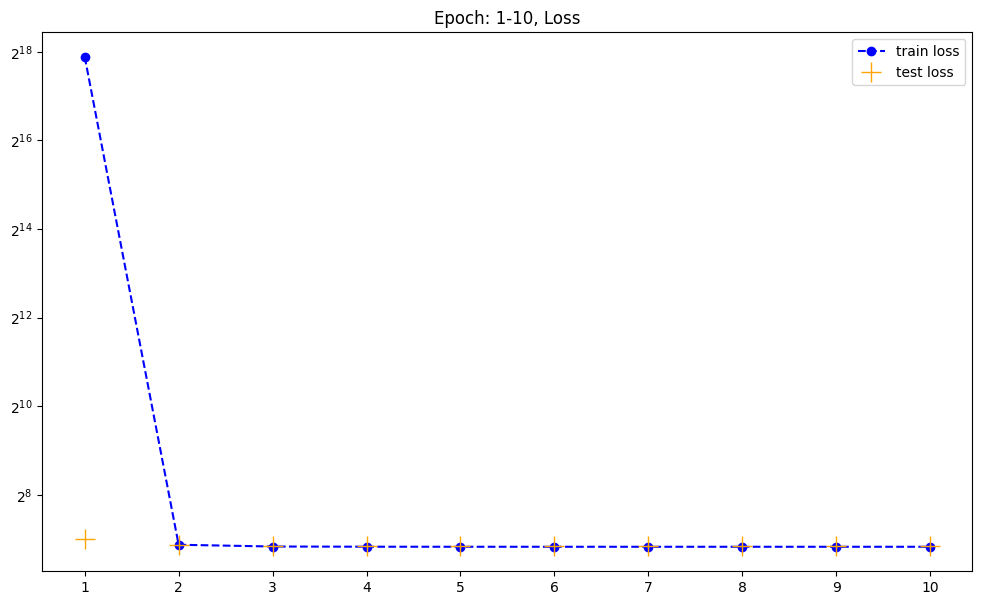

In [ ]:
plt.figure(figsize=(12, 7))
plt.title(f"Epoch: 1-10, Loss")
steps = list(range(1, len(train_losses) + 1))
plt.plot(steps, train_losses, '--bo', label="train loss", zorder=1)
plt.plot(steps, val_losses, marker='+', color="orange", linestyle='', markersize=14, label="test loss", zorder=1)
plt.legend(loc="best")
plt.xticks(steps)
plt.yscale('log', base=2)
plt.show()

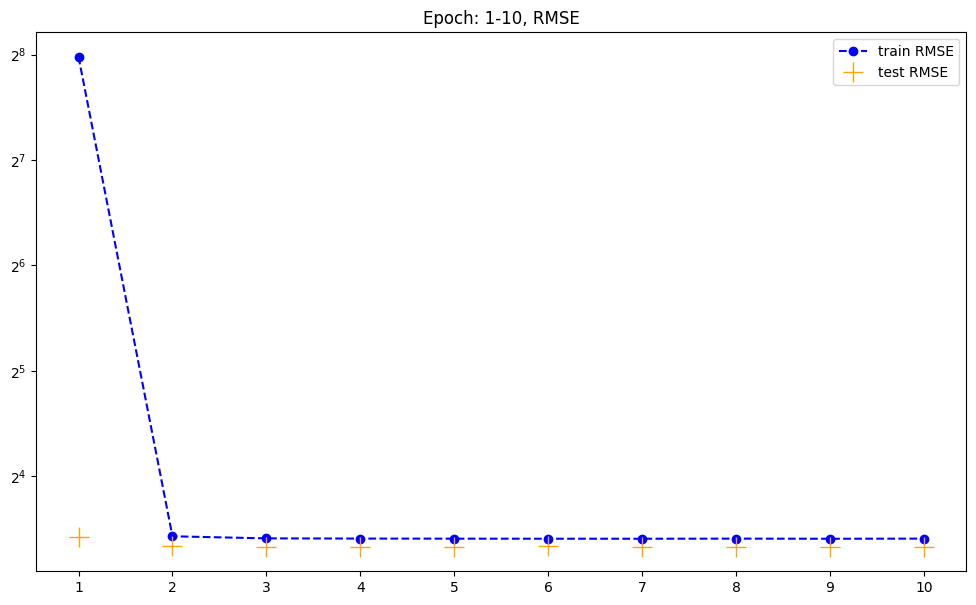

In [ ]:
plt.figure(figsize=(12, 7))
plt.title(f"Epoch: 1-10, RMSE")
steps = list(range(1, len(train_rmses) + 1))
plt.plot(steps, train_rmses, '--bo', label="train RMSE", zorder=1)
plt.plot(steps, val_rmses, marker='+', color="orange", linestyle='', markersize=14, label="test RMSE", zorder=1)
plt.legend(loc="best")
plt.xticks(steps)
plt.yscale('log', base=2)
plt.show()

In [ ]:
def mse_numpy(y_pred, y):
  return np.mean((y_pred - y) ** 2)

In [ ]:
print(f'Loss train final: {mse_numpy(train_pred, lst_train_tru)}, RMSE train final: {mse_numpy(train_pred, lst_train_tru) ** 0.5}')
print(f'Loss test final: {mse_numpy(test_pred, lst_test_tru)}, RMSE test final: {mse_numpy(test_pred, lst_test_tru) ** 0.5}')

Loss train final: 113.13769542502762, RMSE train final: 10.636620488906598
Loss test final: 114.88935705531001, RMSE test final: 10.718645299444796


In [ ]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!
# Thank you :)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def plot_history_by_steps(train_history, test_history):
    plt.figure(figsize=(12, 7))
    plt.title(f"Epoch: 1-{len(train_history)}, RMSE")
    steps = list(range(1, len(train_history) + 1))

    plt.plot(steps, train_history, '--go', marker='X', label="train RMSE", zorder=1)
    plt.plot(steps, test_history, '-ro', marker='D', label="test RMSE", zorder=1)

    plt.legend(loc="best")
    plt.xticks(steps)

    plt.show()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(10)

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size].reshape(-1, 1)
X_test = X[train_size:, :]
y_test = y[train_size:].reshape(-1, 1)

In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
scaler_test = StandardScaler()
y_train = scaler_test.fit_transform(y_train).reshape(1, -1)[0]
y_test = scaler_test.transform(y_test).reshape(1, -1)[0]

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    The dataset needed
    """
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
      return self.x[idx, :], self.y[idx]

In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self):
      super(ModelBaseline, self).__init__()
      self.bn1 = nn.BatchNorm1d(90)
      self.fc1 = nn.Linear(90, 512)
      self.bn2 = nn.BatchNorm1d(512)
      self.gelu1 = nn.GELU()
      self.dro = nn.Dropout(0.29)
      self.fc2 = nn.Linear(512, 512)
      self.bn3 = nn.BatchNorm1d(512)
      self.gelu2 = nn.GELU()
      self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
      x = self.bn1(x)
      x = self.fc1(x)
      x = self.bn2(x)
      x = self.gelu1(x)
      x = self.dro(x)
      x = self.fc2(x)
      x = self.bn3(x)
      x = self.gelu2(x)
      x = self.fc3(x)

      return x

In [ ]:
train_set = Dataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True)

test_set = Dataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

model = ModelBaseline().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.59)
criterion = nn.MSELoss()

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader, scaler=scaler_test):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    lst_train = []
    lst_val = []
    for epoch in range(1, 7):
      print('Epoch: ', epoch)

      train_pred, train_true = np.array([]), np.array([])
      val_pred, val_true = np.array([]), np.array([])

      model.train()
      for x_tr, y_tr in tqdm(train_loader):
        train_true = np.concatenate((train_true, y_tr.detach().numpy()), axis=None)

        x_tr = x_tr.float().to(device)
        y_tr = y_tr.float().to(device)

        y_pred = model(x_tr).unsqueeze(0).unsqueeze(1).squeeze()
        loss = criterion(y_tr, y_pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        y_pred = y_pred.cpu().detach().numpy()

        train_pred = np.concatenate((train_pred, y_pred), axis=None)

      print('-'*75)
      lst_train.append(mean_squared_error(torch.tensor(scaler.inverse_transform(train_true.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), torch.tensor(scaler.inverse_transform(train_pred.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), squared=False))

      model.eval()
      with torch.no_grad():
        for x_val, y_val in test_loader:
          val_true = np.concatenate((val_true, y_val.detach().numpy()), axis=None)

          x_val = x_val.float().to(device)
          y_val = y_val.float().to(device)

          y_pred = model(x_val).unsqueeze(0).unsqueeze(1).squeeze()
          y_pred = y_pred.cpu().detach().numpy()

          val_pred = (np.concatenate((val_pred, y_pred), axis=None))

      lst_val.append(mean_squared_error(torch.tensor(scaler.inverse_transform(val_true.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), torch.tensor(scaler.inverse_transform(val_pred.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), squared=False))

      scheduler.step()

    return lst_train, lst_val


def test(model, criterion, test_loader, scaler=scaler_test):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    test_pred, test_true = np.array([]), np.array([])

    with torch.no_grad():
        for x_test, y_test in test_loader:
            test_true = np.concatenate((test_true, y_test.detach().numpy()), axis=None)

            x_test = x_test.float().to(device)
            y_test = y_test.float().to(device)

            y_pred = model(x_test).unsqueeze(0).unsqueeze(1).squeeze()
            y_pred = y_pred.cpu().detach().numpy()

            test_pred = (np.concatenate((test_pred, y_pred), axis=None))

        print('RMSE на тесте: ', mean_squared_error(torch.tensor(scaler.inverse_transform(test_true.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), torch.tensor(scaler.inverse_transform(test_pred.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), squared=False))

    predicts = torch.tensor(scaler.inverse_transform(test_pred.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze()
    return predicts, mean_squared_error(torch.tensor(scaler.inverse_transform(test_true.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), torch.tensor(scaler.inverse_transform(test_pred.reshape(-1, 1))).unsqueeze(0).unsqueeze(1).squeeze(), squared=False)


In [ ]:
lst_train, lst_val = train(model, optimizer, criterion, train_loader, test_loader)

Epoch:  1


  0%|          | 0/453 [00:00<?, ?it/s]

---------------------------------------------------------------------------
Epoch:  2


  0%|          | 0/453 [00:00<?, ?it/s]

---------------------------------------------------------------------------
Epoch:  3


  0%|          | 0/453 [00:00<?, ?it/s]

---------------------------------------------------------------------------
Epoch:  4


  0%|          | 0/453 [00:00<?, ?it/s]

---------------------------------------------------------------------------
Epoch:  5


  0%|          | 0/453 [00:00<?, ?it/s]

---------------------------------------------------------------------------
Epoch:  6


  0%|          | 0/453 [00:00<?, ?it/s]

---------------------------------------------------------------------------


<ipython-input-25-fd92470a9bdf>:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "--go" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(steps, train_history, '--go', marker='X', label="train RMSE", zorder=1)
<ipython-input-25-fd92470a9bdf>:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(steps, test_history, '-ro', marker='D', label="test RMSE", zorder=1)


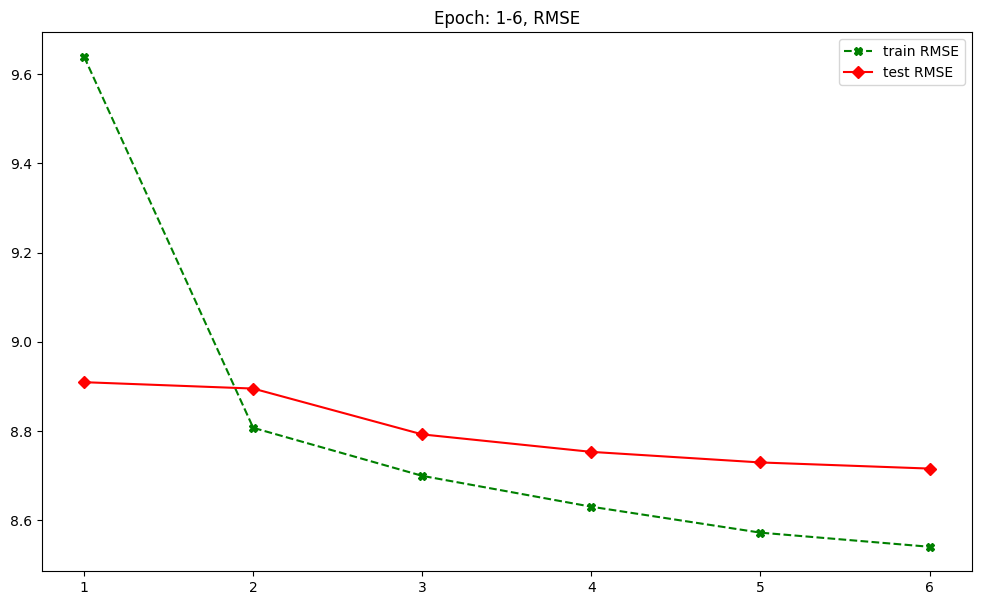

In [ ]:
plot_history_by_steps(lst_train, lst_val)

In [ ]:
predicts, RMSE = test(model, criterion, test_loader)

RMSE на тесте:  8.715776047395817


In [ ]:
assert predicts.detach().numpy().shape[0] == y_test.shape[0]

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Первая моделька, которую я построила, использовала просто три линейных слоя и Relu после первых двух. Не совсем просто, потому что я еще нормализовала таргет, чтобы модельке было проще обучаться и не огромные вещи с большой дисперсией предсказывать, а маленькие, так проще подобрать веса. Понятно, что, когда натренирую модельку, надо преобразовать таргет обратно, что я и делаю. В качестве оптимайзера я выбрала Adam, потому что SGD уже пробовали на паре и хотелось потрогать новое. А еще взяла сразу scheduler, так как нам говорили, что штука полезная. Почитала статейки и нашла ExponentialLR. Результат, на удивление, оказался не такой плохой, когда удалось аккуратно подобрать гиперпараметры (lr=0.0011, gamma=0.5, см. код). Эпох я взяла 7, но график показывает, что 4 вполне себе вариант, потому что после 4-й модель начала переобучаться. Но недостаточный. К слову, батч я взяла размера 128, потому что не хотелось особо долго ждать обучения модели.

На удивление, получилось так, что если внимательно слушал на семинаре и сначала дополнительно немного зарисерчил, почти сразу вышло неплохо. Хотя все равно приходилось перезапускать модель. Но везде я начинала подбор с гиперпараметров, которые были либо дефолтные, либо где-то упоминались в статьях (условно, вот тут вот гамма как раз берется 0.5: https://www.kaggle.com/code/billiemage/understand-lr-scheduler-with-simple-examples, а тут довольно приятная статья про Adam: https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html - в ней learning rate берется 0.001, я попробовала значения около, вышло нормально). И мне кажется, это все сильно ускорило процесс.

Важное! У меня в какой-то момент закончилось в коллабе все, а еще не хотелось перегружать ноутбук другими модельками, чтобы вдруг ничего не сломалось, поэтому примеры моделей на каждом из этапов, описанных здесь, содержатся в других ноутбуках, названия которых вот тут будут отмечены. Никто ведь не запрещал так делать, правда? А сюда я выведу самое важное - скрины графиков, архитектур и итогового значения.

Итак, вот то, что было сначала, наиболее удачная итерация (подробнее смотреть код в "First_model_best_example.ipynb"):


Вот архитектура первой модели:

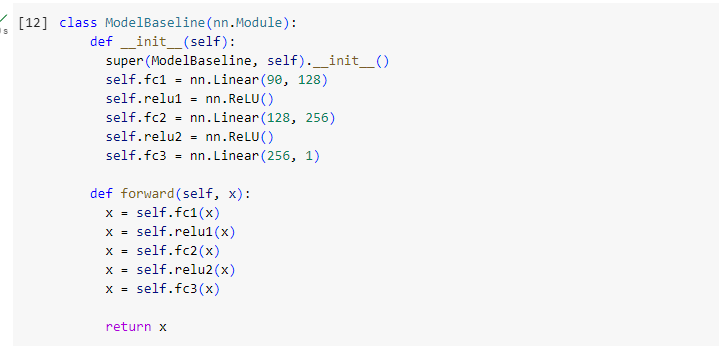

Вот график того, что было во время обучения:

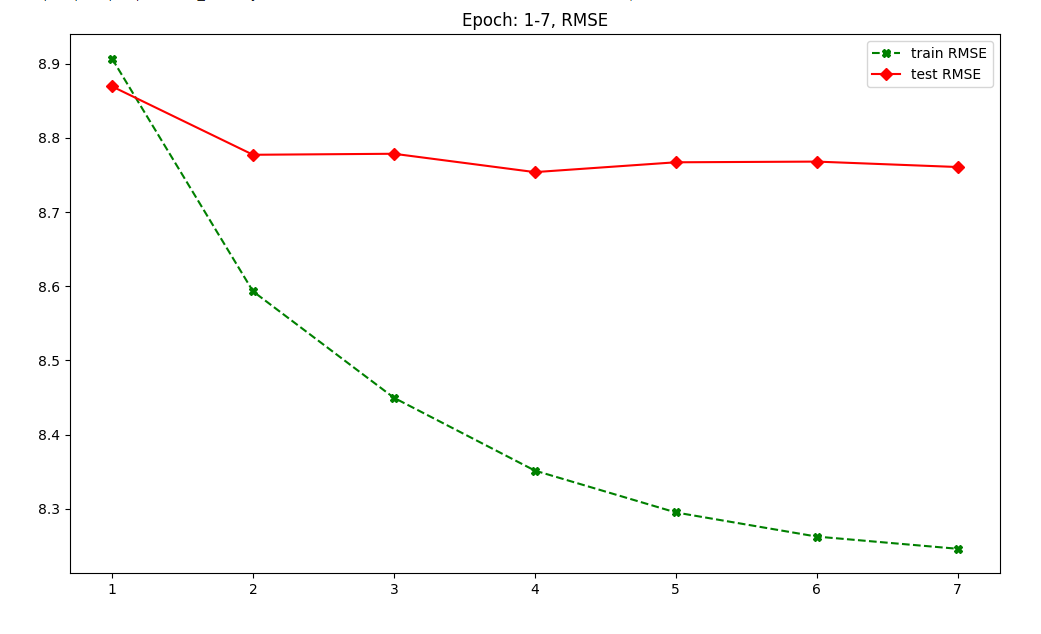

Вот такой результат был на 7-ми эпохах:

 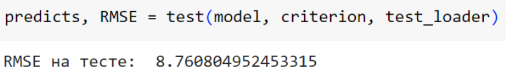

И такой на 4-х:

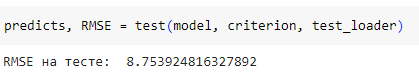

Потом я нашла информацию, что вместо Relu можно использовать GELU (вот тут я про нее почитала: https://paperswithcode.com/method/gelu). Попробовала. Оказалось, что лучше не становится, но и хуже особо не становится тоже, нет, хуже, конечно, но использовать любопытно. Оставила GELU. Решила, что добью до нужного результата ее. Гиперпараметры изменились: learning rate = 0.001, gamma = 0.4. К слову, функции train/eval/test я вообще с начала не меняла, они как-то удачно написались (ну, после кучи глупых ошибок и упущенных мест типа пропущенного loss.backward(), из-за чего все ломалось...). Второй вариант модели лежит тут: "Second_model_best_example.ipynb".


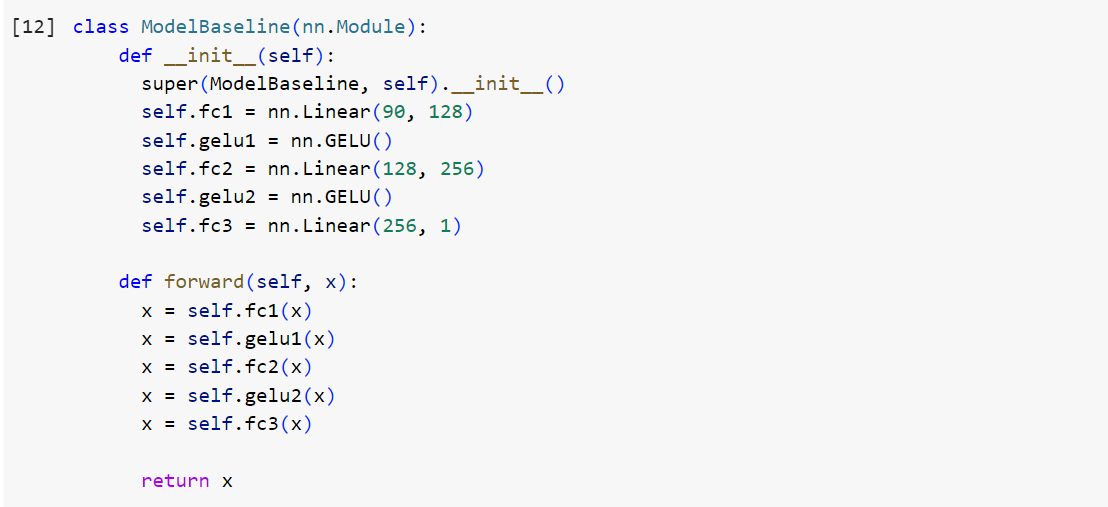

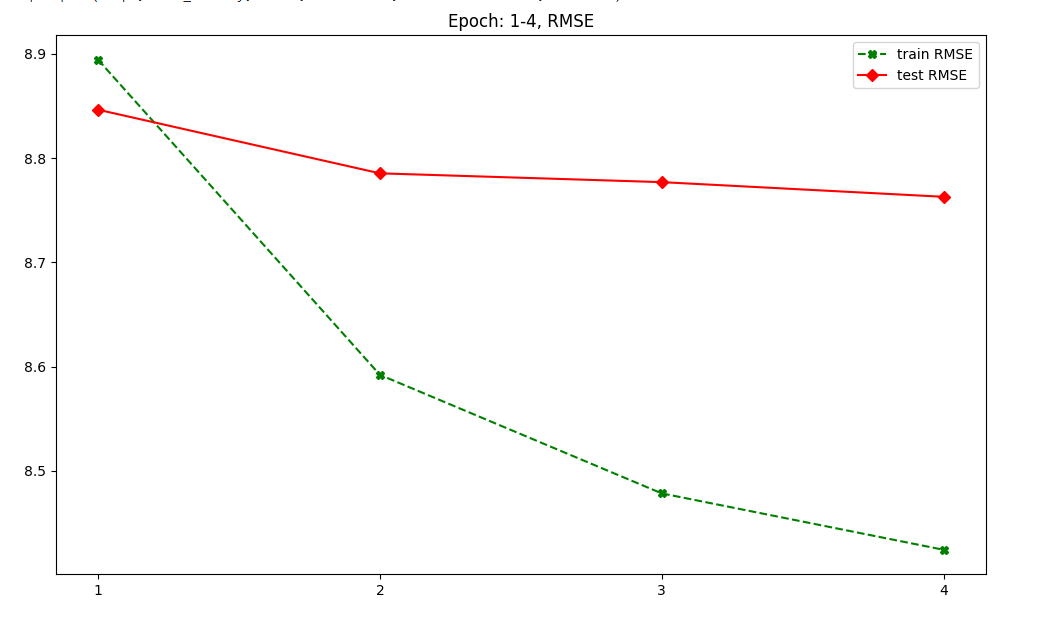

Результат на 4-х эпохах:

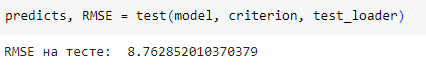

А потом мы на лекции разбирали BatchNorm и Dropout, я попробовала встроить их. Сначала лучше не стало, стало чуть ли не хуже, а потом я начала менять гиперпараметры и переставлять BatchNorm. Вот эта статья мне помогла: https://runebook.dev/ru/docs/pytorch/generated/torch.nn.batchnorm1d. В итоге я остановилась на том, что вы видите выше, только все еще с батчом размера 128 и примерно прежними гиперпараметрами (learning rate = 0.001, gamma = 0.4). У Dropout удалось нащупать парметр равный 0.29. Но результат все еще выходил не очень, сейчас покажу:



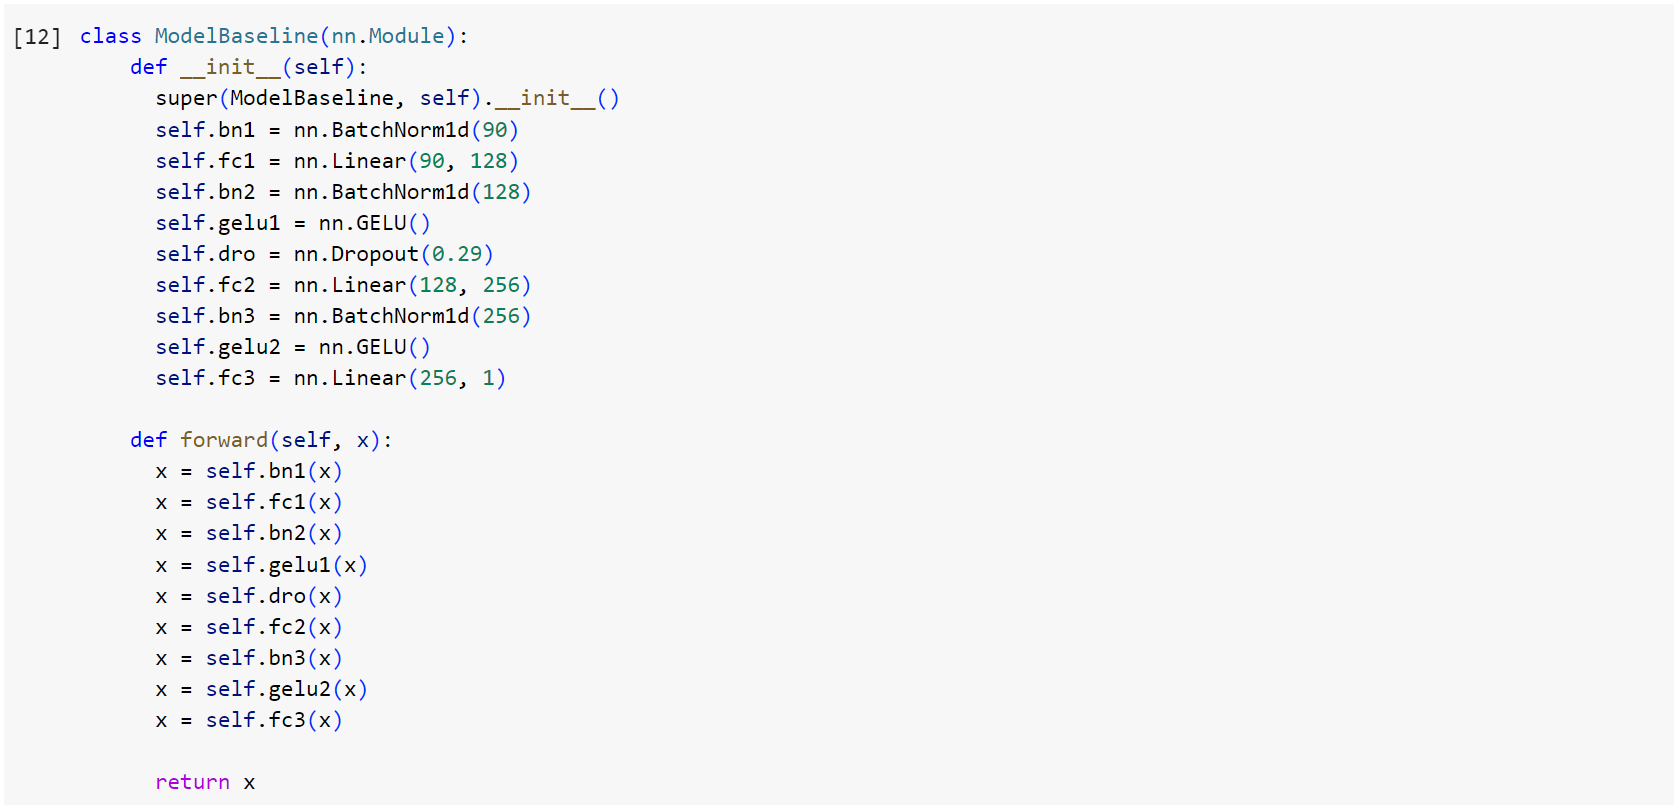

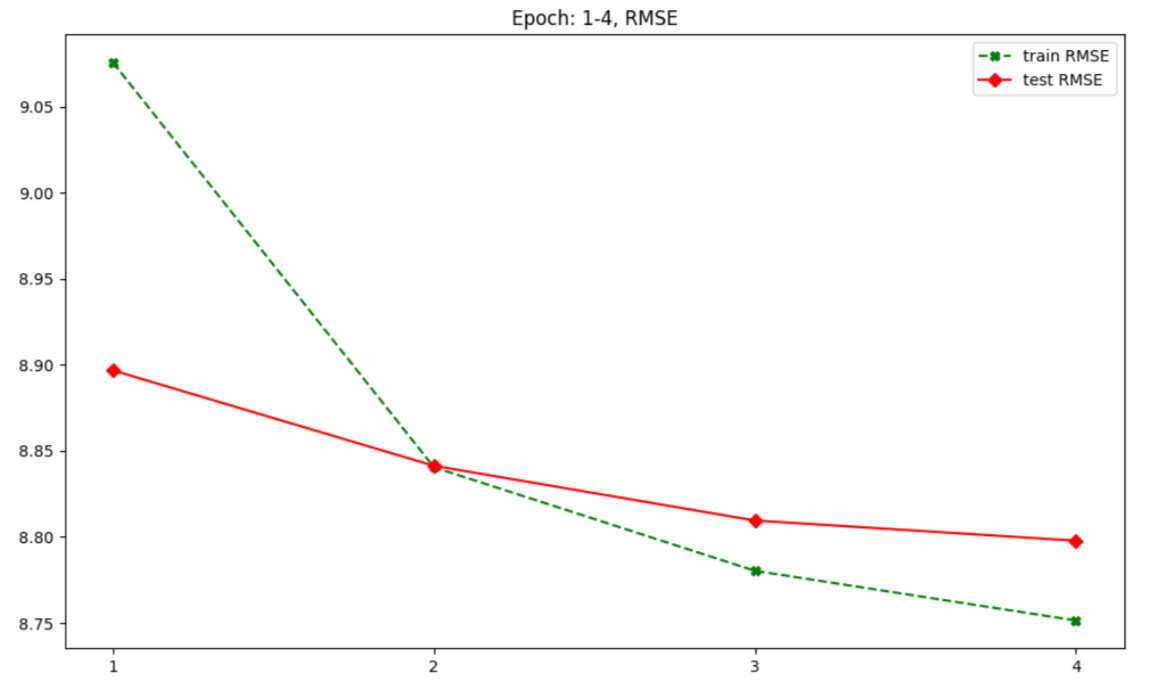

Результат на 4-х эпохах:

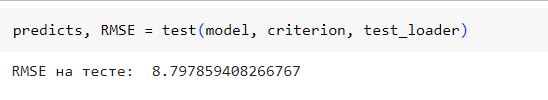

Было грустно, цель стала чуть дальше, чем раньше, поэтому я снова взялась за гиперпараметры. Поскольку раньше в статье про learning rate я прочитала, что оптимальные значения лежат в отрезке от 0.01 до 0.0001 в большинстве случаев, я решила ткнуть сначала в эти границы. Ткнула в 0.01. И вот что вышло:

P.S. Файл этой модели называется "Third_model_best_example.ipynb"

Результат на 4-х эпохах:


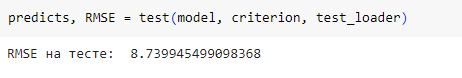

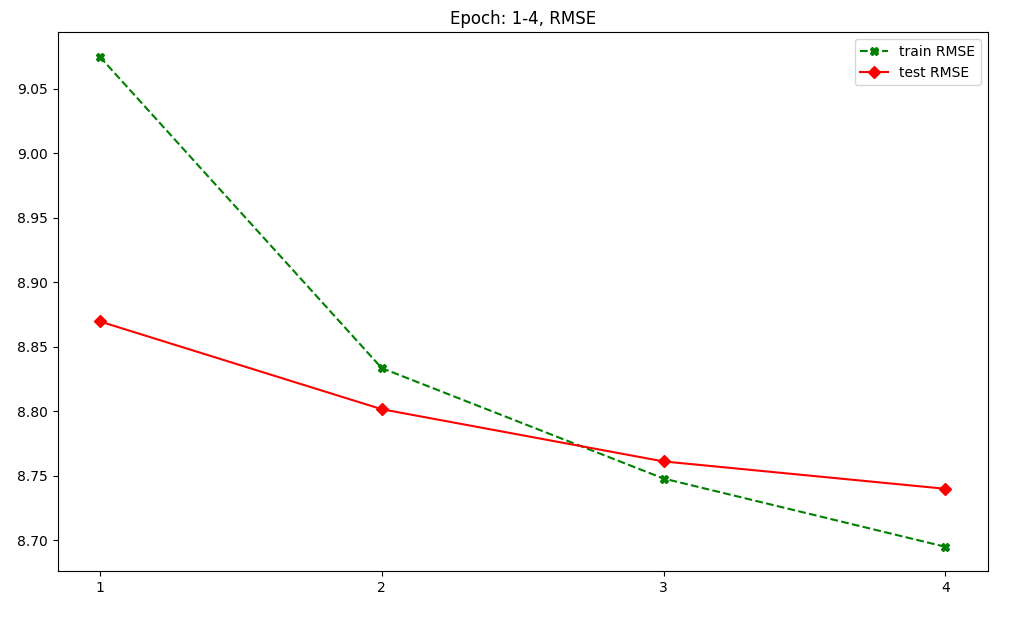

А еще я наткнулась вот на такую картинку в процессе:

https://habrastorage.org/r/w1560/web/225/c44/513/225c44513c21431399c64cd91a9e2036.png

вот в этой статье: https://habr.com/ru/companies/wunderfund/articles/330814/

Там в одном фрагменте кода число нейронов стояло 1024, и я подумала (неочевидная мысль, но я сидела над кодом уже второй день...), что еще можно взять батч побольше - 1024. И я попробовала такую штуку просто, чтобы поиграться, потому что результат на 10-ку уже был, а в итоге вышла модель с результатом повыше, которую вы видите в этом ноутбуке сейчас как финальную.  Слои сделала побольше, понарушала классические рекомендации. Сработало весьма хорошо, что меня удивило. Тут я вернула гамме значение 0.5, потом повысила его до 0.59.

Отчет звучит так, будто все было гораздо проще, чем все мучения в реальности... Но к концу работы домашка мне начала нравиться!

К слову! Вам наверняка интересно, как я вообще выбирала количество эпох. Я брала дефолтное значение около 10-11, потом смотрела на график, по нему отмечала момент, когда начинается переобучение, а потом этот момент и считала конечной эпохой.